In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numba

# Make some dynamics

In [2]:
#[a, -b]
#[b, a]
def construct_diagonal_blocks(vals):
    """ 
    https://math.stackexchange.com/questions/1345694/algorithm-for-real-matrix-given-the-complex-eigenvalues/1345699#1345699
    https://math.stackexchange.com/questions/3218954/construct-a-real-matrix-for-given-complex-eigenvalues
    """
    arrs = []
    for v in vals:
        arr = np.zeros([2,2])
        arr[0,0] = v[0]
        arr[0,1] = -v[1]
        arr[1,0] = v[1]
        arr[1,1] = v[0]
        arrs.append(arr)
    return np.array(arrs)

def fill_diagonal_blocks(arrs):
    return None

In [7]:
n_blocks = 2
tmp = np.random.uniform(0,.2,size=(n_blocks,2))
tmp /= np.linalg.norm(tmp,axis=1)[:,None]

In [8]:
M = np.zeros([n_blocks*2]*2)
for i,db in enumerate(construct_diagonal_blocks(tmp)):
    M[i*2:(i+1)*2,i*2:(i+1)*2] = db

In [9]:
rand_mat = np.random.uniform(size=(n_blocks*2,n_blocks*2))
A = np.dot(rand_mat,M).dot(np.linalg.inv(rand_mat))
Q = np.eye(n_dim)

In [10]:
n_timepoints = 50
n_units = 2
n_dim = A.shape[0]

In [11]:
C = np.random.uniform(0,.005,size=(n_units,n_blocks*2))
R = np.eye(n_units)*2


In [12]:
x0 = np.zeros([n_dim])
latents = np.zeros([n_dim,n_timepoints])  # x|y_{1:t-1}
ys = np.zeros([n_units,n_timepoints])
ys[:,0] = np.random.multivariate_normal(mean=np.dot(C,x0),cov=R)
for t_ in range(1,n_timepoints):
    latents[:,t_] = np.random.multivariate_normal(mean=np.dot(A,latents[:,t_-1]),cov=Q) #- 100*t_/n_timepoints
    ys[:,t_] = np.random.multivariate_normal(mean=np.dot(C,latents[:,t_]),cov=R)

In [13]:
t_ = 1

In [14]:
(2*n_timepoints)/t_

100.0

In [15]:
R*(2*n_timepoints)/t_

array([[200.,   0.],
       [  0., 200.]])

In [16]:
R

array([[2., 0.],
       [0., 2.]])

# Infer those dynamics 

In [17]:
Q.diagonal()

array([1., 1., 1., 1.])

In [290]:

def kf(y,x0,A,C,d,Q,R):
    """ this is the forward kalman filter"""
    n_timepoints = y.shape[1]
    n_dim = Q.shape[0]
    xs_t0 = np.zeros([n_dim,n_timepoints])  # x|y_{1:t-1}
    xs_t1 = np.zeros([n_dim,n_timepoints])  # x|y_{1:t}
    Vs_t0 = np.zeros([n_dim,n_dim,n_timepoints])
    Vs_t1 = np.zeros_like(Vs_t0)
    Vs_t1[:,:,0] = Vs_t0[:,:,0] = np.eye(n_dim)
    #K = np.zeros([n_dim,20])

    xs_t0[:,0] = x0
    xs_t1[:,0] = x0
    Im = np.eye(n_dim)
    for t in range(n_timepoints):
        
        if t>0:
            #prediction step
            xs_t0[:,t] = np.dot(A,xs_t1[:,t-1])  #this is the prior  
            Vs_t0[:,:,t] = np.dot(A,np.dot(Vs_t1[:,:,t-1],A.T)) + Q
        
        #calculate kalman gain
        tmp = np.linalg.inv(np.dot(C,Vs_t0[:,:,t]).dot(C.T) + R)  #1/observation covariance
        K = np.dot(Vs_t0[:,:,t],C.T).dot(tmp)

        #update step
        xs_t1[:,t] = xs_t0[:,t] + np.dot(K,y[:,t] - np.dot(C,xs_t0[:,t]))
        Vs_t1[:,:,t] = Vs_t0[:,:,t] - np.dot(K,C).dot(Vs_t0[:,:,t])
    return xs_t0, xs_t1, Vs_t0, Vs_t1

In [543]:
def ks(A,xs_t0, xs_t1, Vs_t0, Vs_t1):
    """ kalman smoother """
    n_dim,n_timepoints = xs_t1.shape
    
    x_T = np.zeros_like(xs_t1)
    x_T[:,-1] = xs_t1[:,-1]
    v_T = np.zeros_like(Vs_t1)
    v_T[:,:,-1] = Vs_t1[:,:,-1]
    for t_ in reversed(range(n_timepoints-1)):
        J = np.dot(Vs_t1[:,:,t_],A.T).dot(np.linalg.pinv(Vs_t0[:,:,t_+1]))
        #print(xs_t0[:,t_])
        x_T[:,t_] = xs_t1[:,t_] + J.dot(x_T[:,t_+1] - xs_t0[:,t_+1])
        v_T[:,:,t_] = Vs_t1[:,:,t_] + J.dot(v_T[:,:,t_+1] - Vs_t0[:,:,t_+1]).dot(J.T)
    
    return x_T, v_T
    

In [544]:
def _smooth_update(transition_matrix, filtered_state_mean,
                   filtered_state_covariance, predicted_state_mean,
                   predicted_state_covariance, next_smoothed_state_mean,
                   next_smoothed_state_covariance):

    kalman_smoothing_gain = (
        np.dot(filtered_state_covariance,
               np.dot(transition_matrix.T,
                      linalg.pinv(predicted_state_covariance)))
    )
    print(filtered_state_mean)
    smoothed_state_mean = (
        filtered_state_mean
        + np.dot(kalman_smoothing_gain,
                 next_smoothed_state_mean - predicted_state_mean)
    )
    smoothed_state_covariance = (
        filtered_state_covariance
        + np.dot(kalman_smoothing_gain,
                 np.dot(
                    (next_smoothed_state_covariance
                        - predicted_state_covariance),
                    kalman_smoothing_gain.T
                 ))
    )

    return (smoothed_state_mean, smoothed_state_covariance,
            kalman_smoothing_gain)


def _smooth(transition_matrices, filtered_state_means,
            filtered_state_covariances, predicted_state_means,
            predicted_state_covariances):

    n_timesteps, n_dim_state = filtered_state_means.shape

    smoothed_state_means = np.zeros((n_timesteps, n_dim_state))
    smoothed_state_covariances = np.zeros((n_timesteps, n_dim_state,
                                           n_dim_state))
    kalman_smoothing_gains = np.zeros((n_timesteps - 1, n_dim_state,
                                       n_dim_state))

    smoothed_state_means[-1] = filtered_state_means[-1]
    smoothed_state_covariances[-1] = filtered_state_covariances[-1]

    for t in reversed(range(n_timesteps - 1)):
        transition_matrix = _last_dims(transition_matrices, t)
        (smoothed_state_means[t], smoothed_state_covariances[t],
         kalman_smoothing_gains[t]) = (
            _smooth_update(
                transition_matrix,
                filtered_state_means[t],
                filtered_state_covariances[t],
                predicted_state_means[t + 1],
                predicted_state_covariances[t + 1],
                smoothed_state_means[t + 1],
                smoothed_state_covariances[t + 1]
            )
        )
    return (smoothed_state_means, smoothed_state_covariances,
            kalman_smoothing_gains)

In [545]:
from pykalman import KalmanFilter
from pykalman.standard import _filter
kalman= KalmanFilter(initial_state_mean=x0,
                  #n_dim_obs=n_units,n_dim_state=n_dim,
                  transition_matrices=A,
                  observation_matrices=C,
                  observation_covariance=R,
                  transition_covariance=Q,
                     initial_state_covariance=np.eye(4)
                     #init
                 )
#The traditional Kalman Filter assumes that model parameters are known beforehand. 
#The KalmanFilter class however can learn parameters using KalmanFilter.em() (fitting is optional). 
#Then the hidden sequence of states can be predicted using KalmanFilter.smooth():

#measurements = [[1,0], [0,0], [0,1]]
#>>> kf.em(measurements).smooth([[2,0], [2,1], [2,2]])[0]


In [546]:
def _last_dims(X, t, ndims=2):
    """Extract the final dimensions of `X`
    Extract the final `ndim` dimensions at index `t` if `X` has >= `ndim` + 1
    dimensions, otherwise return `X`.
    Parameters
    ----------
    X : array with at least dimension `ndims`
    t : int
        index to use for the `ndims` + 1th dimension
    ndims : int, optional
        number of dimensions in the array desired
    Returns
    -------
    Y : array with dimension `ndims`
        the final `ndims` dimensions indexed by `t`
    """
    X = np.asarray(X)
    if len(X.shape) == ndims + 1:
        return X[t]
    elif len(X.shape) == ndims:
        return X
    else:
        raise ValueError(("X only has %d dimensions when %d" +
                " or more are required") % (len(X.shape), ndims))



In [547]:
from pykalman.standard import _filter_predict
from scipy import linalg

In [550]:
xs_t0.T

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.21861857e-04, -9.83004189e-04, -6.07840299e-03,
        -3.87049006e-03],
       [ 2.73672904e-03, -4.80784255e-03, -4.04519077e-02,
        -1.88739332e-02],
       [ 8.99343318e-02,  2.81624906e-02, -6.78772163e-02,
        -7.16335474e-02],
       [ 6.25564358e-02, -2.50257284e-02, -1.05029462e-01,
        -1.66026433e-01],
       [-1.06206123e-01, -2.75407374e-01, -2.73653155e-01,
        -5.86161865e-01],
       [ 1.43507038e+00,  1.84950417e+00,  1.65820829e+00,
         2.35333223e+00],
       [-1.22528399e+00, -7.81075784e-01, -8.02970674e-01,
         9.78177991e-01],
       [-2.19940255e+00, -2.10866206e+00, -1.65114223e+00,
        -3.38744640e-01],
       [-1.45425160e+00, -1.65440458e+00, -7.09552389e-01,
        -9.36312728e-01],
       [ 4.69085099e-01,  7.58871266e-01,  1.34929373e+00,
         1.14510752e+00],
       [-6.78143854e-01,  9.02268246e-02,  2.01023378e-01,
      

In [551]:
oot = _filter(A,C,Q,R,np.zeros(n_dim),np.zeros(n_units),x0,Q,ys.T)
(predicted_state_means, predicted_state_covariances,
         _, filtered_state_means, filtered_state_covariances) = oot

In [552]:
_smooth(A, filtered_state_means,
            filtered_state_covariances, predicted_state_means,
            predicted_state_covariances)

[33.13829352 36.63494878 23.24590784 17.29973187]
[24.6827596  21.37253177 20.99687465 -7.37262226]
[-16.6362345  -20.99039454 -12.01727932 -31.71629157]
[-42.14290667 -40.5162593  -28.39703486 -28.66971561]
[-29.95481263 -23.37673605 -10.18767946  -6.28943269]
[-6.62174766 -1.25920818 13.66451402  8.96301517]
[ 9.57265117  8.57117601 21.03091934 11.01008988]
[8.360126   2.66392945 5.45349641 6.86180721]
[ -9.83761831 -11.09891593 -19.1185428    6.9023168 ]
[ 7.66156943 11.52588475 -4.34124104 23.24737768]
[31.38228016 34.09875169 19.14374698 25.52657727]
[30.79963448 28.33111216 19.77049282  7.18546285]
[  1.67220035  -2.22363237  -4.43655179 -15.68441617]
[-21.10100609 -21.03488579 -19.04055834 -20.45403685]
[-12.3875268  -10.20610319  -5.88502683  -9.61347974]
[-15.70439443 -11.83419646  -1.68439461  -6.62876382]
[-2.882323   -1.83915532 10.09140005 -0.93826636]
[-0.98091153 -3.50622608  5.65827945 -1.46700477]
[-5.79269145 -8.49652769 -6.88775525 -0.06471747]
[ 0.19976543 -0.263538

(array([[-3.60386239e-01,  4.30990033e-01, -1.69338345e-02,
         -8.48708195e-02],
        [-1.80506828e+00, -9.62446391e-01, -2.96883174e+00,
         -1.07226100e+00],
        [-1.16288985e+00, -1.78066240e+00, -4.73513028e+00,
         -2.25985062e+00],
        [ 3.64829178e+00,  1.60042357e+00, -5.49492648e-01,
         -8.48501613e-01],
        [ 8.46704815e+00,  7.11626181e+00,  6.43224239e+00,
          3.78510755e+00],
        [ 6.54786961e+00,  7.56384477e+00,  7.33872403e+00,
          7.43630205e+00],
        [-2.04673283e+00, -3.60965161e-02, -3.43774042e-01,
          5.27063312e+00],
        [-8.47020864e+00, -8.23961505e+00, -7.03865265e+00,
         -1.28722765e+00],
        [-5.97078770e+00, -7.93750285e+00, -3.42252596e+00,
         -5.38675571e+00],
        [ 8.61473044e-01, -3.90943483e-01,  6.34714375e+00,
         -3.21389564e+00],
        [ 1.40071490e+00,  3.45890246e+00,  8.40971208e+00,
          6.30123599e-01],
        [-6.48403800e+00, -2.57415367e+00, 

In [553]:
xs_t0, xs_t1, Vs_t0, Vs_t1 = kf(ys,np.zeros([n_dim]),A,C,0,Q,R)
x_T,v_T = ks(A,xs_t0,xs_t1, Vs_t0, Vs_t1)

In [554]:
a[1][-1]

array([[807.4135648 , 758.44462221, 542.24280502, 412.20347952],
       [758.44462221, 751.30834043, 544.56006724, 459.03432444],
       [542.24280502, 544.56006724, 591.57887751, 317.1416221 ],
       [412.20347952, 459.03432444, 317.1416221 , 505.40800017]])

In [555]:
a[0][-1]

array([12.24061118, 17.59191856, -4.9000308 , 20.87124314])

In [556]:
o1,o2 = kalman.filter(ys.T)

In [557]:
o1[-1]

array([  3.32039883,   8.6175073 , -12.18997798,  14.56890412])

In [558]:
xs_t0[:,-1]

array([12.24061118, 17.59191856, -4.9000308 , 20.87124314])

In [559]:
xs_t1[:,-1]

array([  3.32039883,   8.6175073 , -12.18997798,  14.56890412])

In [560]:
o1[-1]

array([  3.32039883,   8.6175073 , -12.18997798,  14.56890412])

In [561]:
o1,o2 = kalman.smooth(ys.T)

In [562]:
o1[-2]

array([25.62226231, 30.83264629, 19.20274311, 16.14414297])

In [563]:
x_T[:,-2]

array([25.62226231, 30.83264629, 19.20274311, 16.14414297])

In [564]:
v_T[:,:,-2]

array([[739.49635756, 696.64158616, 496.67978088, 380.77682249],
       [696.64158616, 693.86969425, 502.9592301 , 428.07937217],
       [496.67978088, 502.9592301 , 555.74890182, 294.41613651],
       [380.77682249, 428.07937217, 294.41613651, 485.32528865]])

In [565]:
o2[-2]

array([[739.49635756, 696.64158616, 496.67978088, 380.77682249],
       [696.64158616, 693.86969425, 502.9592301 , 428.07937217],
       [496.67978088, 502.9592301 , 555.74890182, 294.41613651],
       [380.77682249, 428.07937217, 294.41613651, 485.32528865]])

In [452]:
o1[0]

array([-0.36038624,  0.43099003, -0.01693383, -0.08487082])

In [453]:
xs_t1[:,0]

array([-0.00247551, -0.00131694, -0.00350813, -0.00387373])

In [454]:
predicted_state_mean, predicted_state_covariance = _filter_predict(A,Q,0,xs[:,-1],np.eye(4))

NameError: name 'xs' is not defined

In [152]:
ii,jj = (np.dot(A,xs[:,-1]),
 np.dot(A,Q).dot(A.T) + Q)


NameError: name 'xs' is not defined

In [932]:
np.allclose(predicted_state_mean,ii)

True

In [933]:
np.allclose(predicted_state_covariance,jj)

True

In [894]:
observation_offset = 0
observation_matrix = C
observation_covariance = R
observation =ys[:,5]

In [918]:
predicted_observation_mean = (
    np.dot(observation_matrix,
           predicted_state_mean)
    + observation_offset
)
predicted_observation_covariance = (
    np.dot(observation_matrix,
           np.dot(predicted_state_covariance,
                  observation_matrix.T))
    + observation_covariance
)

kalman_gain = (
    np.dot(predicted_state_covariance,
           np.dot(observation_matrix.T,
                  np.linalg.pinv(predicted_observation_covariance)))
)

corrected_state_mean = (
    predicted_state_mean
    + np.dot(kalman_gain, observation - predicted_observation_mean)
)
corrected_state_covariance = (
    predicted_state_covariance
    - np.dot(kalman_gain,
             np.dot(observation_matrix,
                    predicted_state_covariance))
)


In [925]:
#calculate kalman gain
tmp = np.linalg.inv(np.dot(C,predicted_state_covariance).dot(C.T) + R)  #1/observation covariance
K = np.dot(predicted_state_covariance,C.T).dot(tmp)

#update step
ii= predicted_state_mean + np.dot(K,observation - np.dot(C,predicted_state_mean))
jj= predicted_state_covariance - np.dot(K,C).dot(predicted_state_covariance)


In [926]:
(
    predicted_state_covariance
    - np.dot(kalman_gain,
             np.dot(observation_matrix,
                    predicted_state_covariance))
)

array([[9.53951485, 4.82067926, 1.22800595, 6.87847032],
       [4.82067926, 4.50966941, 1.07212855, 4.41263446],
       [1.22800595, 1.07212855, 1.82554243, 0.61077373],
       [6.87847032, 4.41263446, 0.61077373, 8.07242386]])

In [927]:
np.allclose(corrected_state_covariance,jj)

True

In [928]:
np.allclose(corrected_state_mean,ii)

True

In [922]:
jj

array([[9.53951485, 4.82067926, 1.22800595, 6.87847032],
       [4.82067926, 4.50966941, 1.07212855, 4.41263446],
       [1.22800595, 1.07212855, 1.82554243, 0.61077373],
       [6.87847032, 4.41263446, 0.61077373, 8.07242386]])

In [924]:
corrected_state_covariance

array([[9.53951485, 4.82067926, 1.22800595, 6.87847032],
       [4.82067926, 4.50966941, 1.07212855, 4.41263446],
       [1.22800595, 1.07212855, 1.82554243, 0.61077373],
       [6.87847032, 4.41263446, 0.61077373, 8.07242386]])

In [723]:
b.shape

(50, 4, 4)

In [724]:
ks

<function __main__.ks(A, xs_t0, xs_t1, Vs_t0, Vs_t1)>

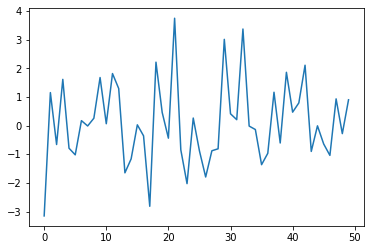

In [725]:
plt.plot(ys[0])

In [726]:
xs_t0, xs_t1, Vs_t0, Vs_t1 = kf(ys,np.zeros([n_dim]),A,C,0,Q,R)
x_T,v_T = ks(A,xs_t0, xs_t1, Vs_t0, Vs_t1)

(0, 50)

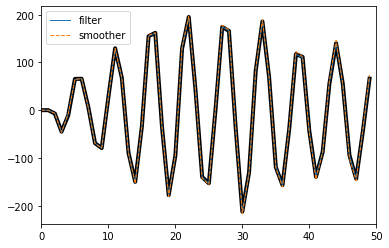

In [727]:
plt.plot(xs[0],linewidth=4,color='k')
plt.plot(xs_t0[0],label='filter',linewidth=1)
plt.plot(x_T[0],label='smoother',linewidth=1,linestyle='--')
plt.legend()
plt.xlim(0,50)

In [238]:
ys[:,0] - np.dot(C,xs[:,0])

array([ 5.0637935 ,  0.80427807, -1.70974408, -1.54927839, -1.45319829,
       -2.14209687, -1.61639117, -1.26873418, -0.70390773, -2.24563272,
       -1.38058376, -5.08717907, -3.38379425, -6.53876204, -8.13038897,
        3.33432999,  1.09685489, -0.48249698,  1.83374796,  2.72704046])

In [67]:
ys[:,0]

array([-1.47796044e-01,  2.27547694e-01,  8.73411571e-01,  6.48399553e-01,
       -1.42656704e+00, -1.01281960e+00,  3.32053589e-01,  1.27641465e+00,
        7.66734199e-01,  1.34799688e+00, -1.13476663e+00,  4.44043368e-01,
        4.52134971e-01,  4.03421077e-01,  2.24377768e+00, -4.90907569e-01,
       -2.11073823e-03, -7.87427130e-01, -6.66878127e-01, -1.82419542e+00])